# **Heartbeat sounds**

## Import Libraries

In [ ]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa  # Pour traiter les fichiers audio
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf

# Importation des couches et modules de Keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, concatenate, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Importation des fonctions d'évaluation des performances
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
start_time = time.time()

In [ ]:
# parent folder of sound files
data_path="/content/drive/MyDrive/datasets/Heartbeat_Sound"
print(os.listdir(data_path))

['extrahls', 'murmur', 'normal', 'artifact', 'extrastole', 'unlabel']


In [ ]:
tarin_data      = data_path
unlabel_data    = data_path  + "/unlabel/"

normal_data     = tarin_data + '/normal/'
murmur_data     = tarin_data + '/murmur/'
extrastole_data = tarin_data + '/extrastole/'
artifact_data   = tarin_data + '/artifact/'
extrahls_data   = tarin_data + "/extrahls/"

In [ ]:
print("Normal files:", len(os.listdir(normal_data))) #length of normal training sounds
print("Murmur files:",len(os.listdir(murmur_data))) #length of murmur training sounds
print("Extrastole files", len(os.listdir(extrastole_data))) #length of extrastole training sounds
print("Artifact files:",len(os.listdir(artifact_data))) #length of artifact training sounds
print("Extrahls files:",len(os.listdir(extrahls_data))) #length of extrahls training sounds

print('TOTAL TRAIN SOUNDS:', len(os.listdir(normal_data))
                              + len(os.listdir(murmur_data))
                              + len(os.listdir(extrastole_data))
                              + len(os.listdir(artifact_data))
                              + len(os.listdir(extrahls_data)))

Normal files: 351
Murmur files: 129
Extrastole files 46
Artifact files: 40
Extrahls files: 19
TOTAL TRAIN SOUNDS: 585


In [ ]:
print("Test sounds: ", len(os.listdir(unlabel_data)))


Test sounds:  247


## EDA and Visualization


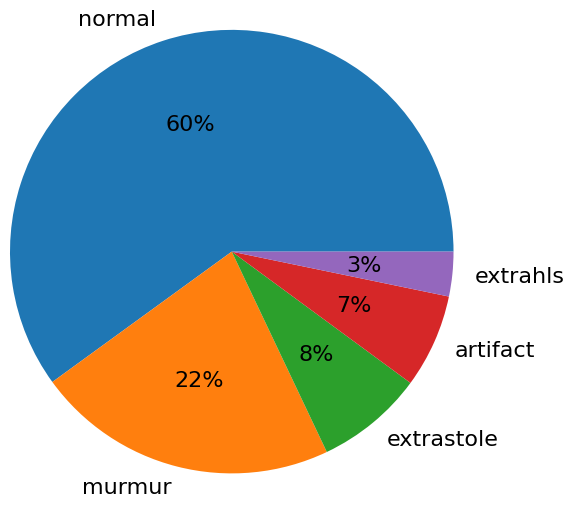

In [ ]:
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(murmur_data)),
              len(os.listdir(extrastole_data)),
              len(os.listdir(artifact_data)),
              len(os.listdir(extrahls_data))])
labels = ['normal', 'murmur', 'extrastole', 'artifact', 'extrahls']
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, textprops={'fontsize': 16})
plt.show()

In [ ]:
# Listen to rondom audio from specific class
def random_sound (audio_class):
    random_sound = np.random.randint(0,len(os.listdir(audio_class)))
    sound_path = os.listdir(audio_class)[random_sound]
    sound_path = audio_class+sound_path
    sound,sample_rate = librosa.load(sound_path)
    return ipd.Audio(sound,rate=sample_rate),sound , sound_path

### **Waveform**

Sound is the pressure of air propagates to our ear. Digital audio file is gotten from a sound sensor that can detects sound waves and converting it to electrical signals. Specifically, it's telling us about the wave's displacement, and how it changes over time.texte en italique

X axis, represents time. Y-axis measures displacement of air molecules.This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.

In [ ]:
# show waveform of audio from dataset
# X axis, represents time.
# Y-axis measures displacement of air molecules.
# This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.

def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20,5))
    librosa.display.waveshow(audio_sample, sr = 22050)
#    plt.title("Sound")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

### **Spectrum**
A sound spectrum is a representation of a sound – usually a short sample of a sound – in terms of the amount of vibration at each individual frequency. It is usually presented as a graph of either power or pressure as a function of frequency. The power or pressure is usually measured in decibels and the frequency is measured in vibrations per second (or hertz, abbreviation Hz) or thousands of vibrations per second (kilohertz, abbreviation kHz).

The spectrum expresses the frequency composition of the sound and is obtained by analyzing the sound. A sound spectrum is usually represented in a coordinate plane where the frequency f is plotted along the axis of abscissas and the amplitude A, or intensity, of a harmonic component with a given frequency is plotted along the axis of ordinates.

In [ ]:
# show spectrum of audio from dataset
def show_audio_spectrum(audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)
    magnitude_normal = np.abs(fft_normal)
    freq_normal = np.linspace(0,sample_rate, len(magnitude_normal))
    half_freq = freq_normal[:int(len(freq_normal)/2)]
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

    plt.figure(figsize=(12,8))
    plt.plot(half_freq,half_magnitude)
    plt.title("Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

### **Spectogram**
For us, as human, we sense a sound not only on a particular time by its intensity, but also by its pitch. The pitch is the frequency of the sound - higher pitch corresponding to higher frequency and vice versa. So, to have a representation which is closer to our brain, we can add another dimension - the frequency - to our representation, which is the Spectrogram.

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams.

Spectrograms are used extensively in the fields of music, linguistics, sonar, radar, speech processing,seismology, and others. Spectrograms of audio can be used to identify spoken words phonetically, and to analyse the various calls of animals.it can be generated by an optical spectrometer, a bank of band-pass filters, by Fourier transform or by a wavelet transform.

In [ ]:
# show specrogram of audio from dataset
# the output is an image that represents a sound.
# X-axis is for time, y-axis is for frequency and the color is for intensity
def show_spectrogram (audio_sample):
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # display spectrogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #plt.set_cmap("YlOrBr")
    plt.title("Spectrogram")

### **MFCCs**
We can’t take the raw audio signal as input to our model because there will be a lot of noise in the audio signal. It is observed that extracting features from the audio signal and using it as input to the base model will produce much better performance than directly considering raw audio signal as input. MFCC is the widely used technique for extracting the features from the audio signal.

in sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

**MFCCs are commonly derived as follows:**

1- Take the Fourier transform of (a windowed excerpt of) a signal.

2- Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows or alternatively, cosine overlapping windows.

3- Take the logs of the powers at each of the mel frequencies.

4- Take the discrete cosine transform of the list of mel log powers, as if it were a signal.

5- The MFCCs are the amplitudes of the resulting spectrum.

In [ ]:
def show_mfcc_features(audio_sample_path):
    hop_length = 512 # en nombre d'échantillons
    n_fft = 2048 # fenêtre en nombre d'échantillons

    # Charger l'échantillon audio
    audio_sample, sample_rate = librosa.load(audio_sample_path, sr=None)

    # Extraire les MFCCs
    MFCCs = librosa.feature.mfcc(y=audio_sample, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=52)

    # Afficher les MFCCs
    plt.figure(figsize=(15,10))
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Temps")
    plt.ylabel("Coefficients MFCC")
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()


## **Dataset Classes**



1.   **Normal**




In [ ]:
normal_audio, normal_sample, normal_path  = random_sound(normal_data)
normal_audio

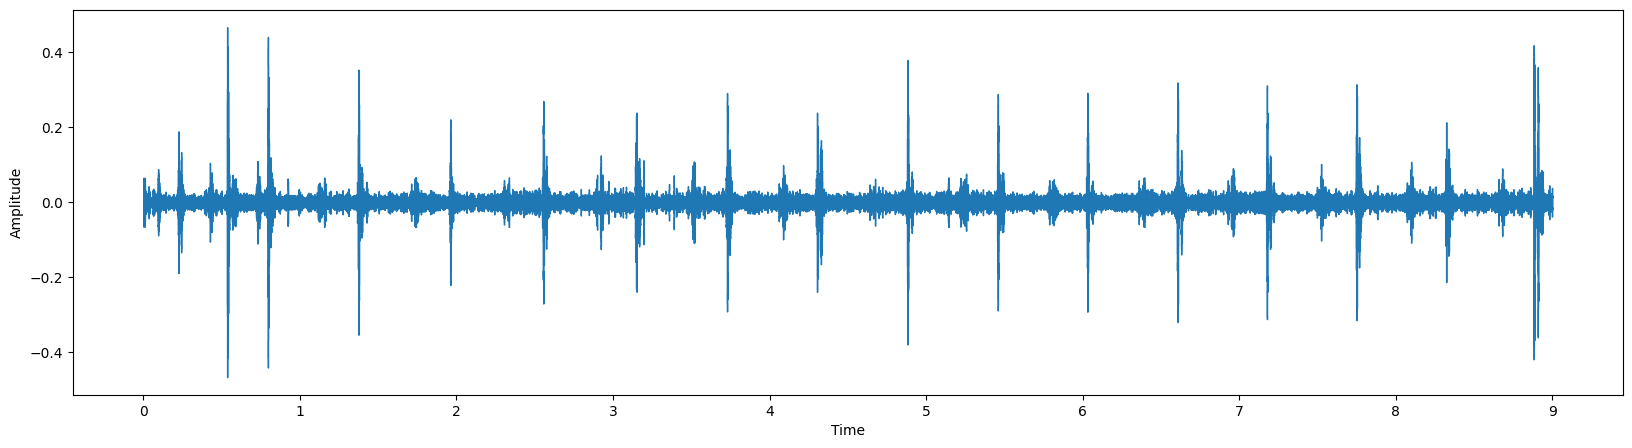

In [ ]:
show_audio_waveform(normal_sample)

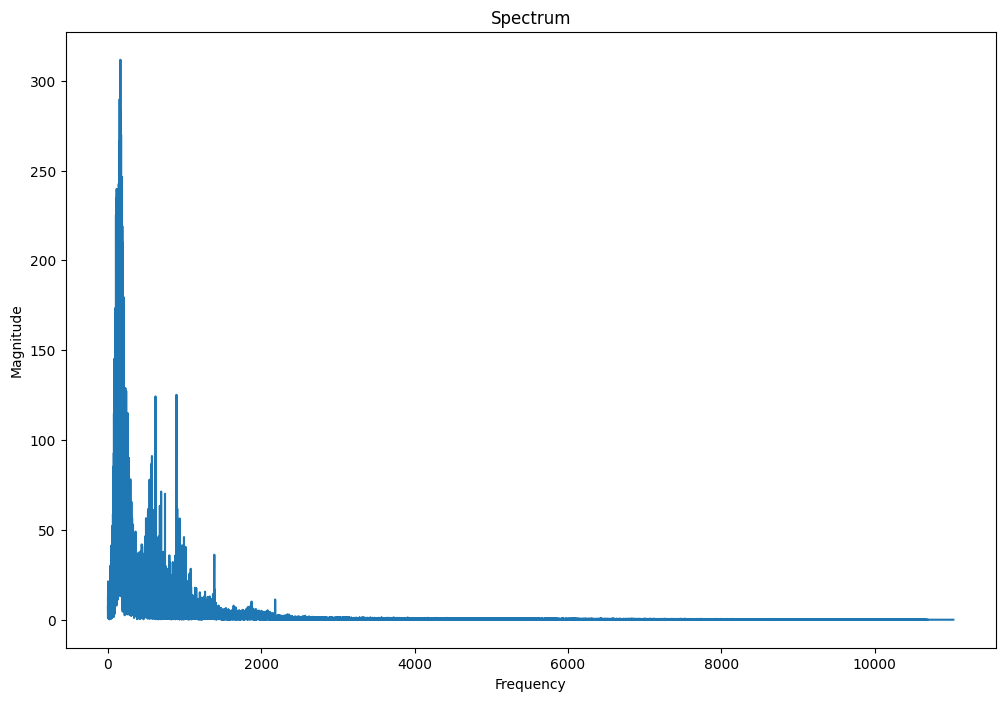

In [ ]:
show_audio_spectrum(normal_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


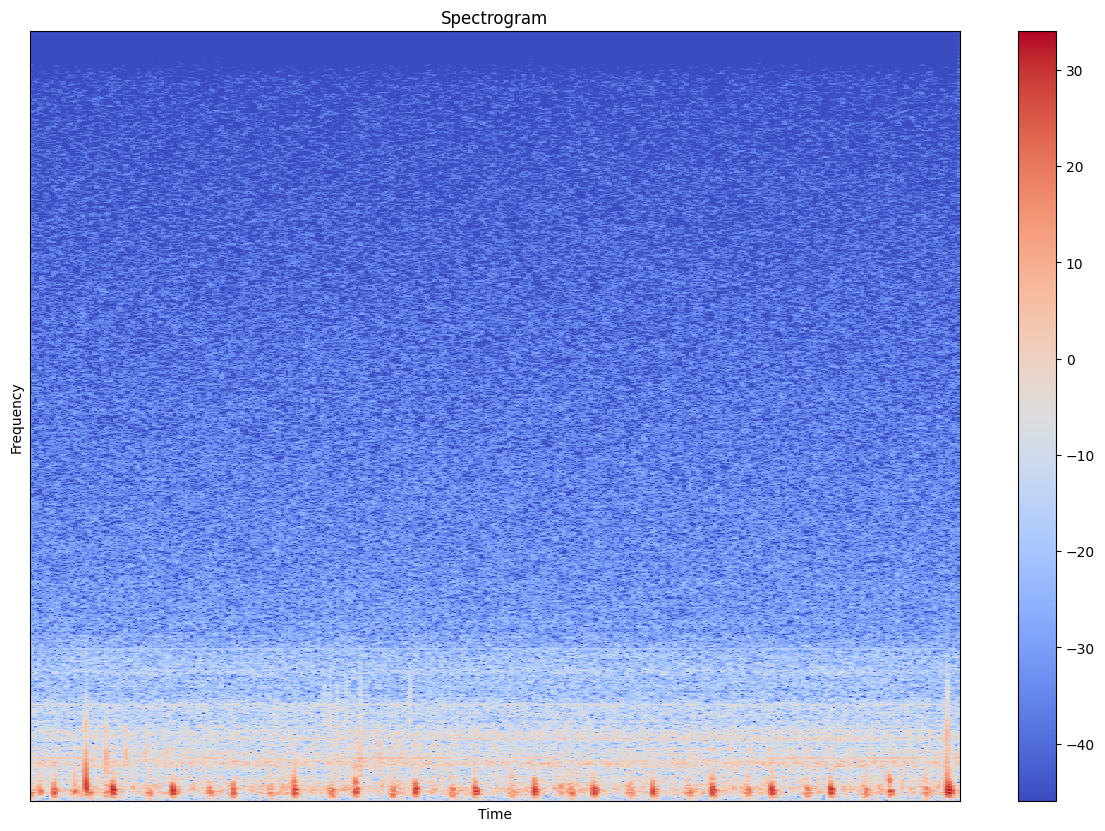

In [ ]:
show_spectrogram(normal_sample)

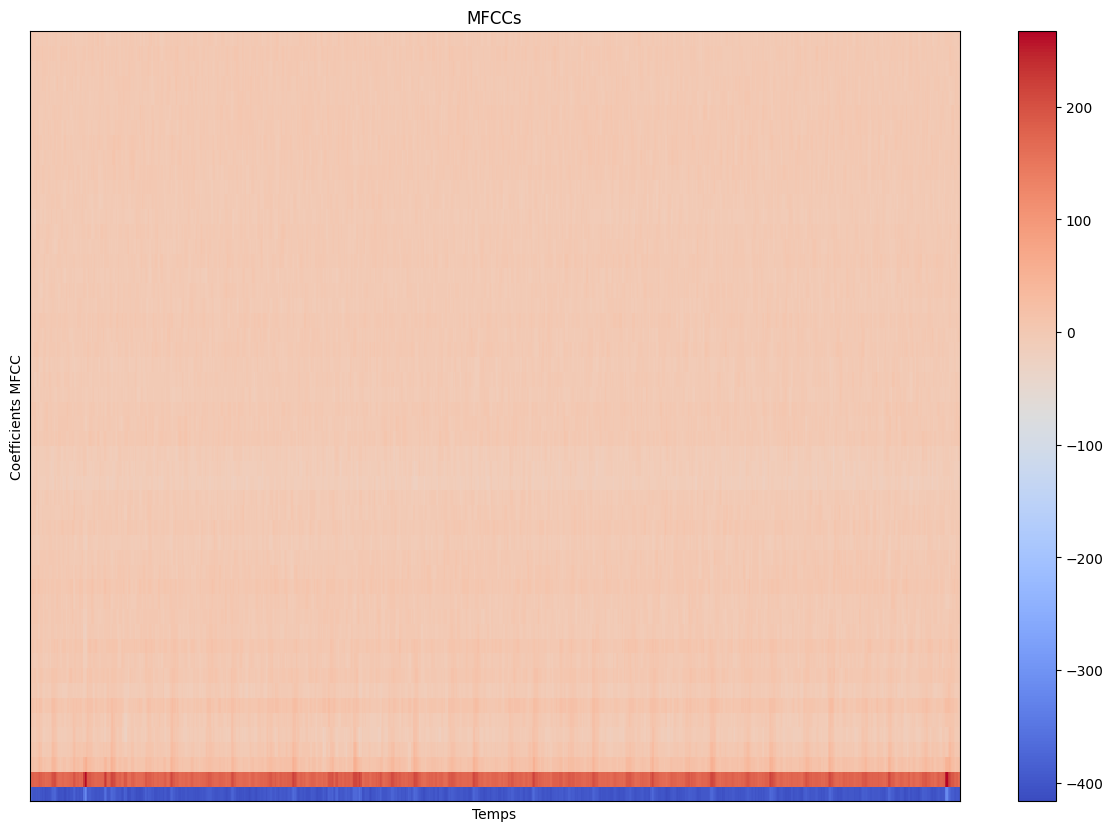

In [ ]:
show_mfcc_features(normal_path)

2.   **Murmur sound**



In [ ]:
murmur_audio, murmur_sample , murmur_path  = random_sound(murmur_data)
murmur_audio

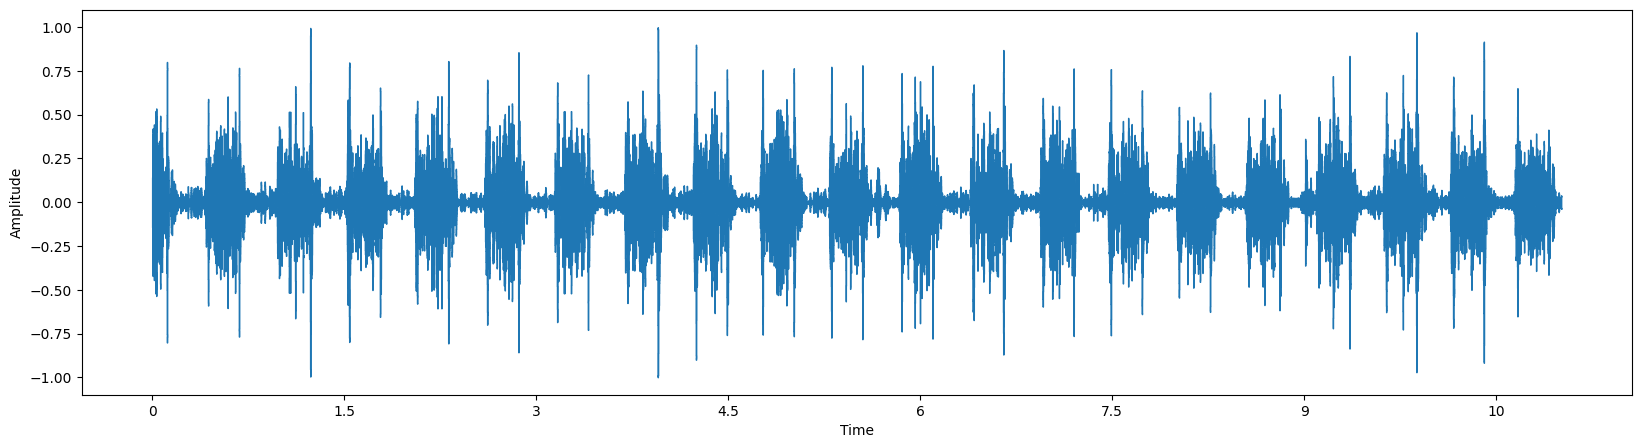

In [ ]:
show_audio_waveform(murmur_sample)

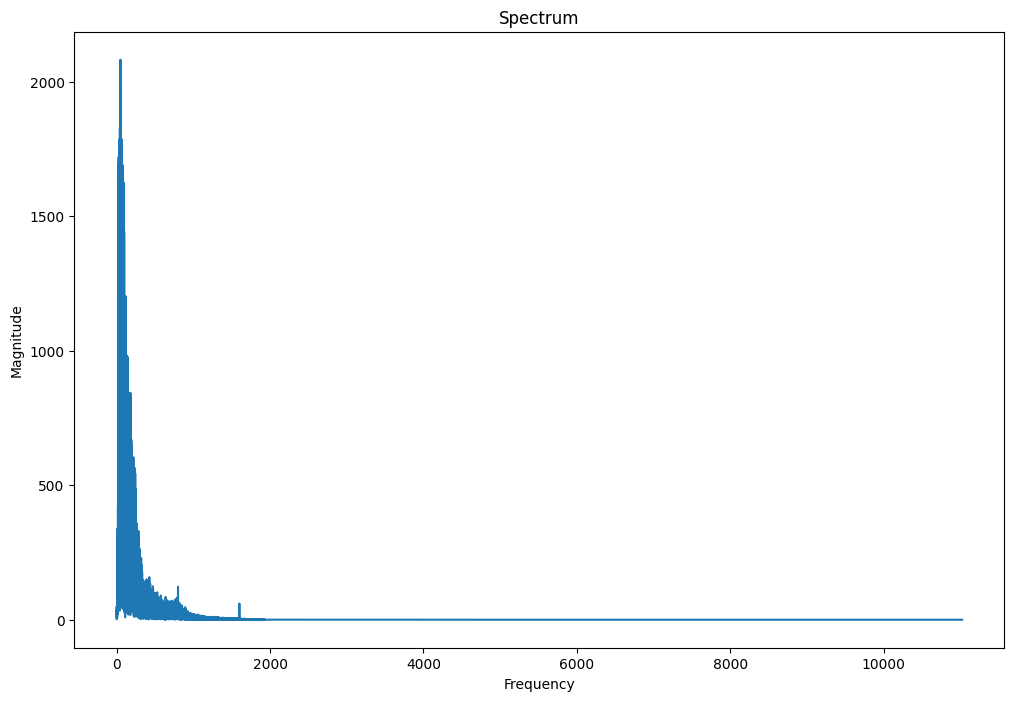

In [ ]:
show_audio_spectrum(murmur_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


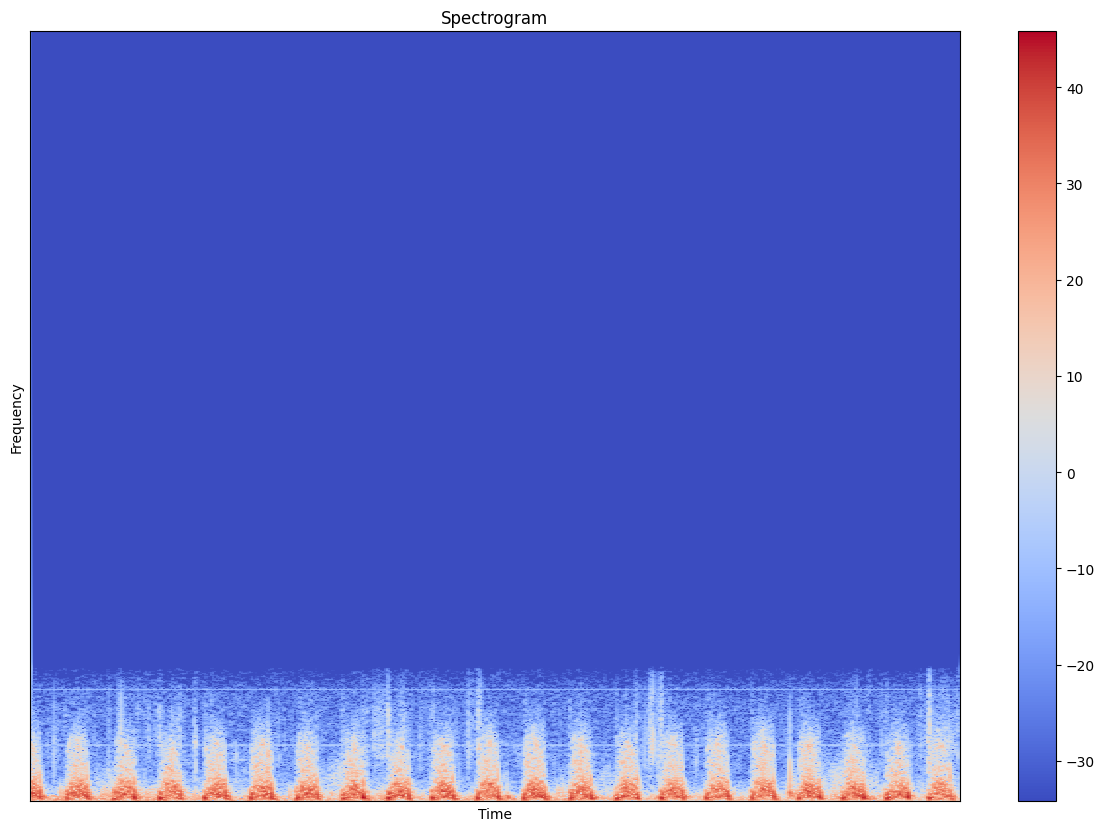

In [ ]:
show_spectrogram(murmur_sample)

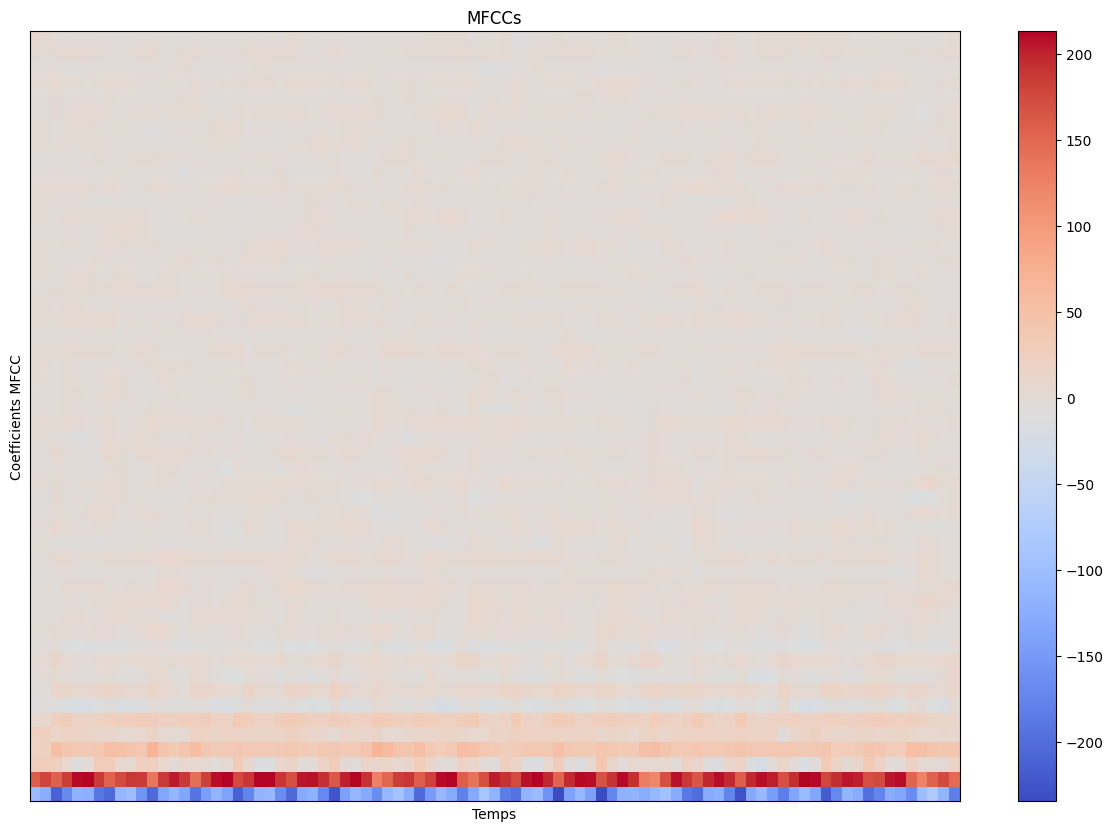

In [ ]:
show_mfcc_features(murmur_path)


3. **Extrastole sound**



In [ ]:
extrastole_audio, extrastole_sample, extrastole_path = random_sound(extrastole_data)
extrastole_audio

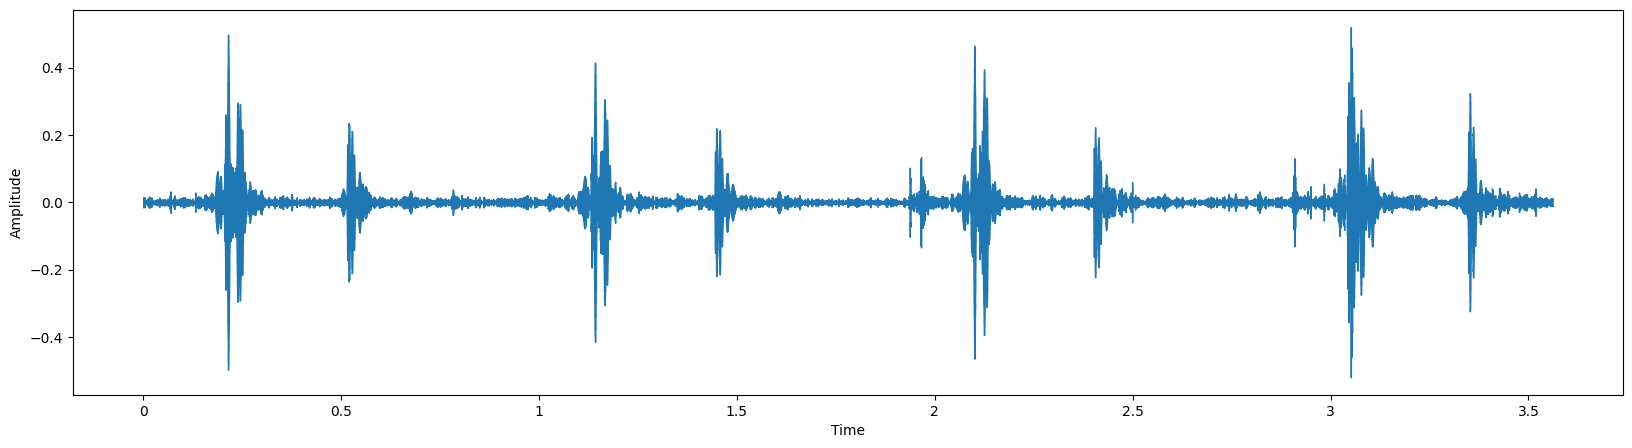

In [ ]:
show_audio_waveform(extrastole_sample)

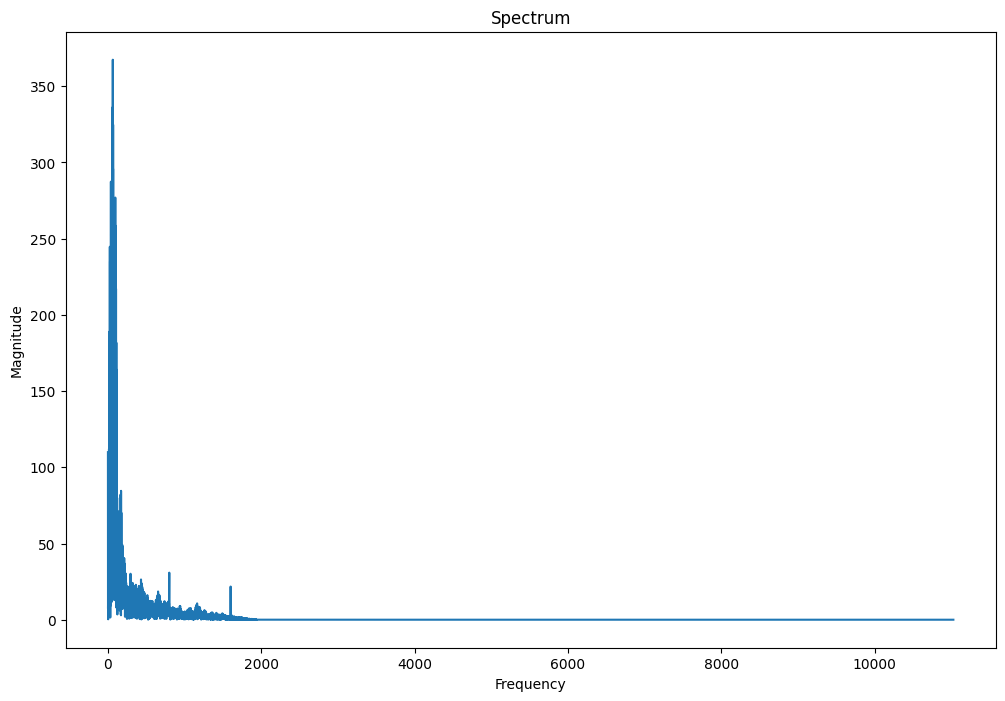

In [ ]:
show_audio_spectrum(extrastole_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


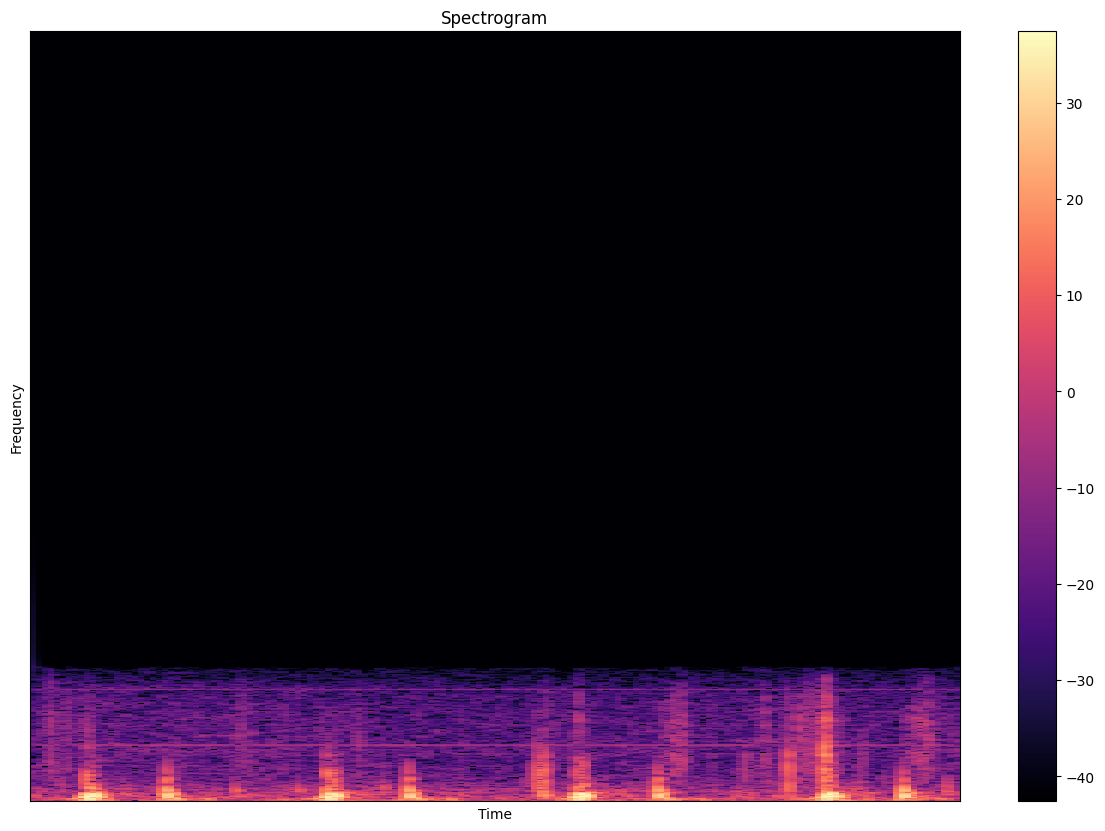

In [ ]:
show_spectrogram(extrastole_sample)

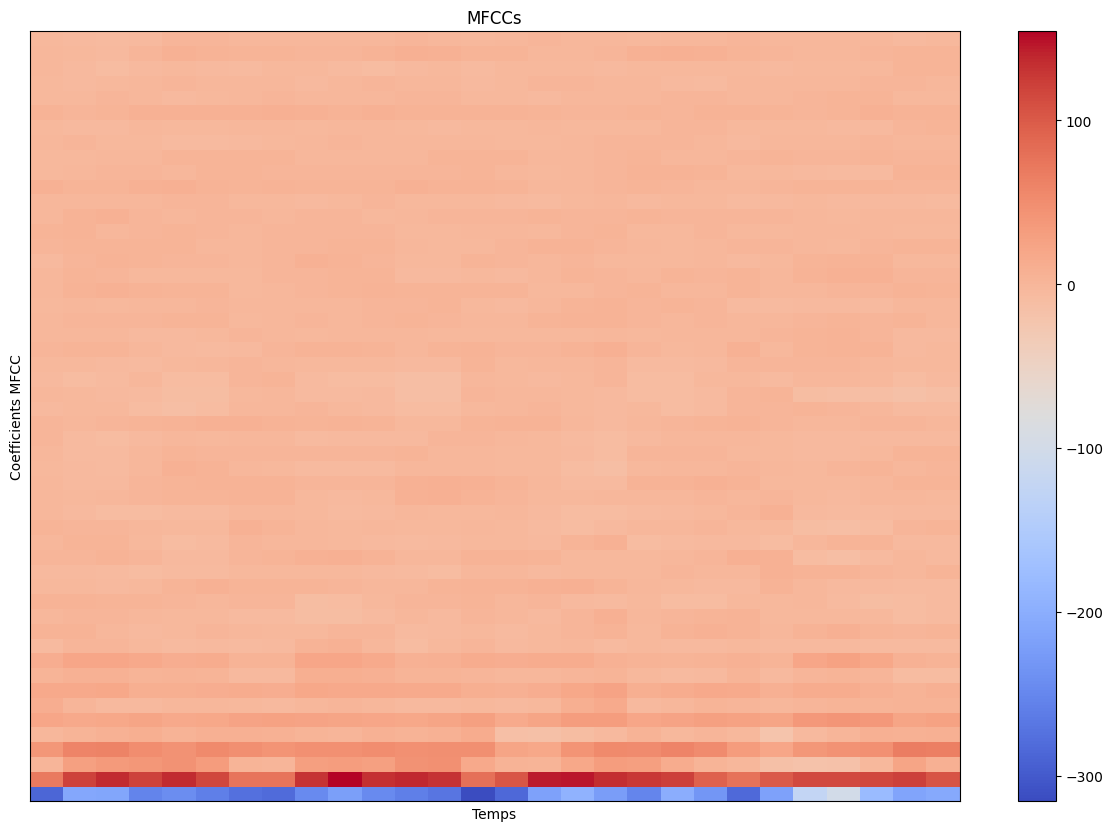

In [ ]:
show_mfcc_features(extrastole_path)

4. **Artifact sound**

In [ ]:
artifact_audio, artifact_sample, artifact_path = random_sound(artifact_data)
artifact_audio

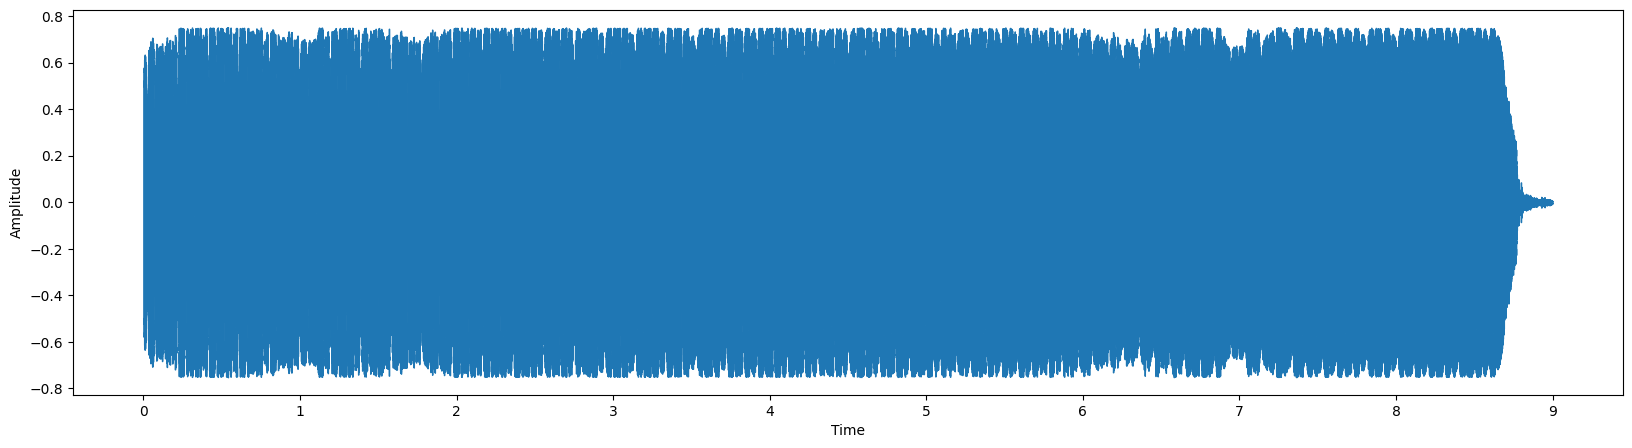

In [ ]:
show_audio_waveform(artifact_sample)

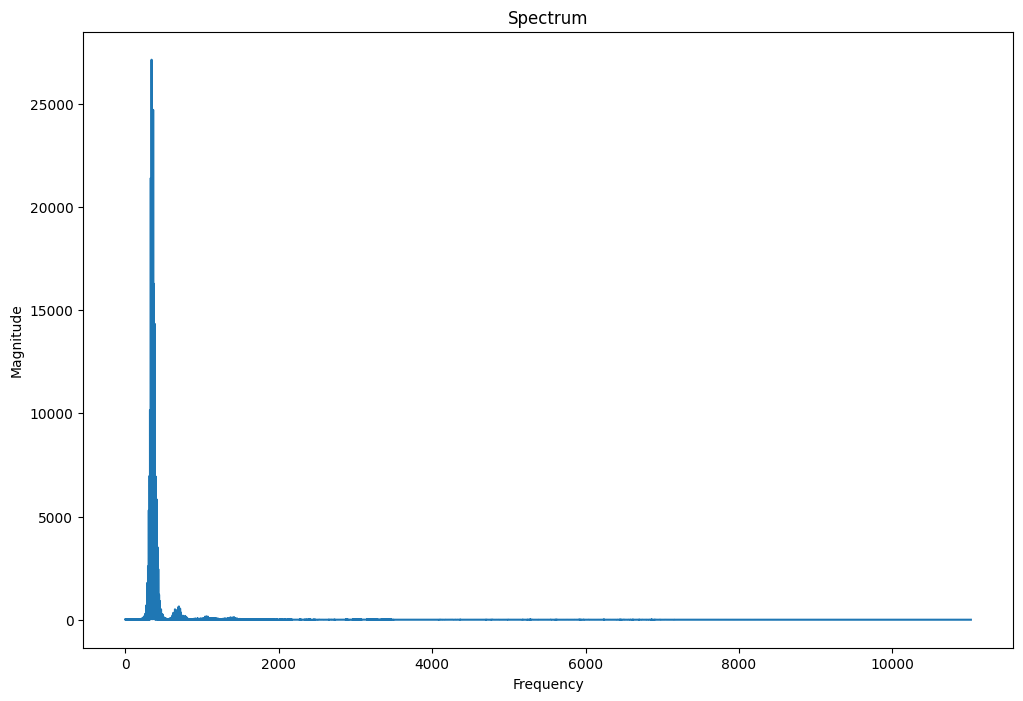

In [ ]:
show_audio_spectrum(artifact_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


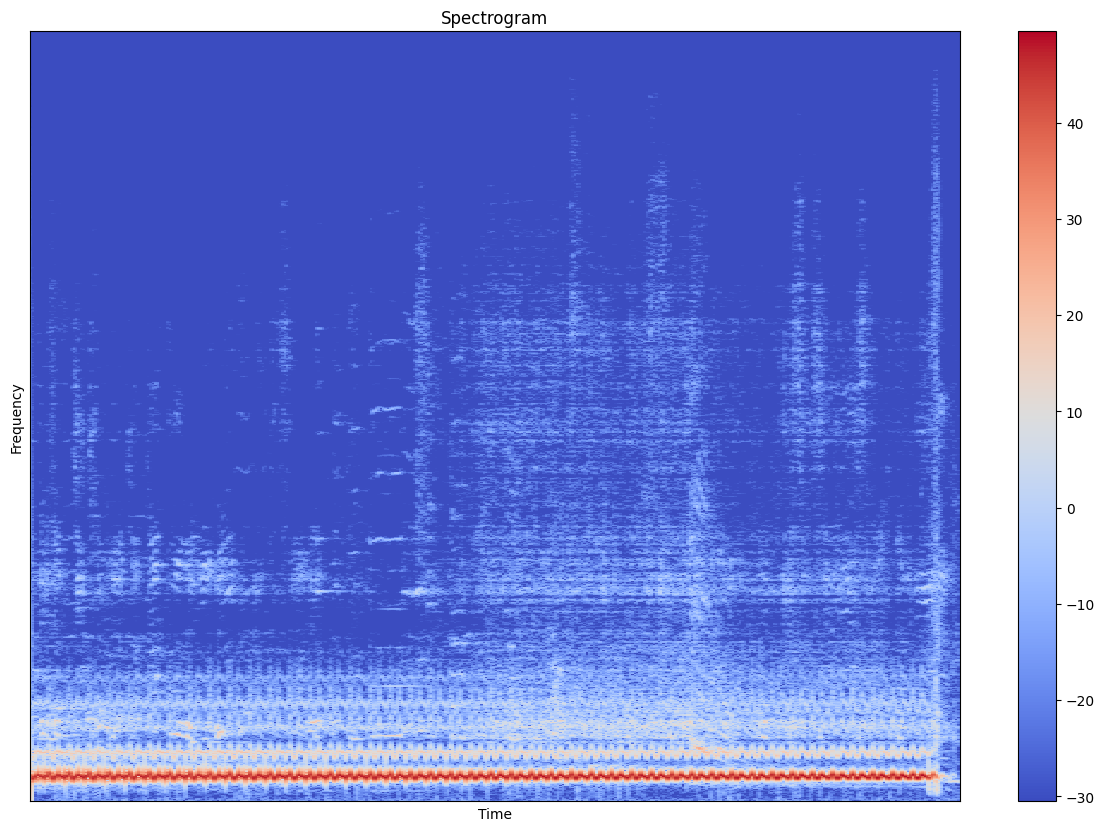

In [ ]:
show_spectrogram(artifact_sample)

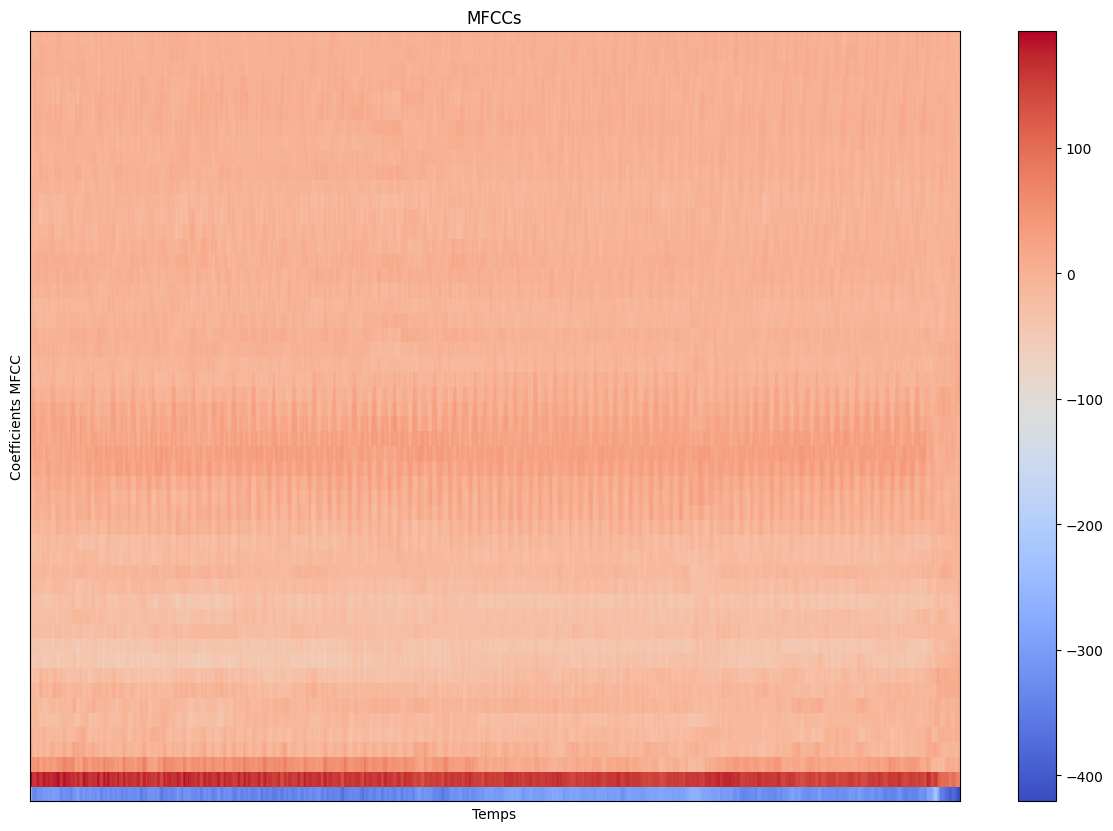

In [ ]:
show_mfcc_features(artifact_path)

5. **Extrahls sound**

In [ ]:
extrahls_audio, extrahls_sample, extrahls_path  = random_sound(extrahls_data)
extrahls_audio

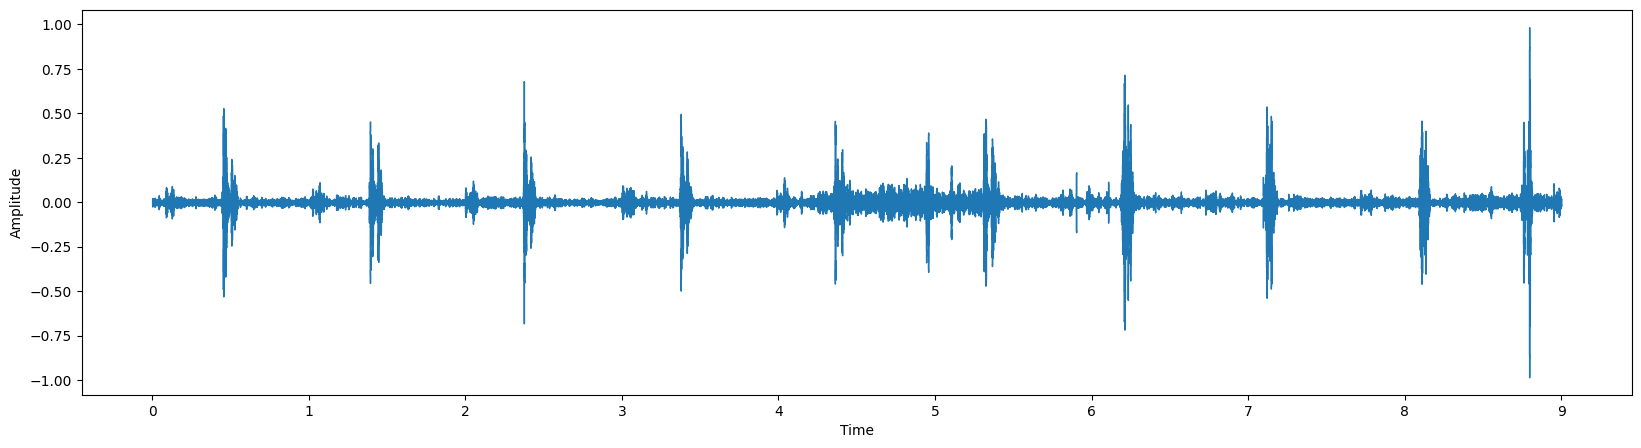

In [ ]:
show_audio_waveform(extrahls_sample)

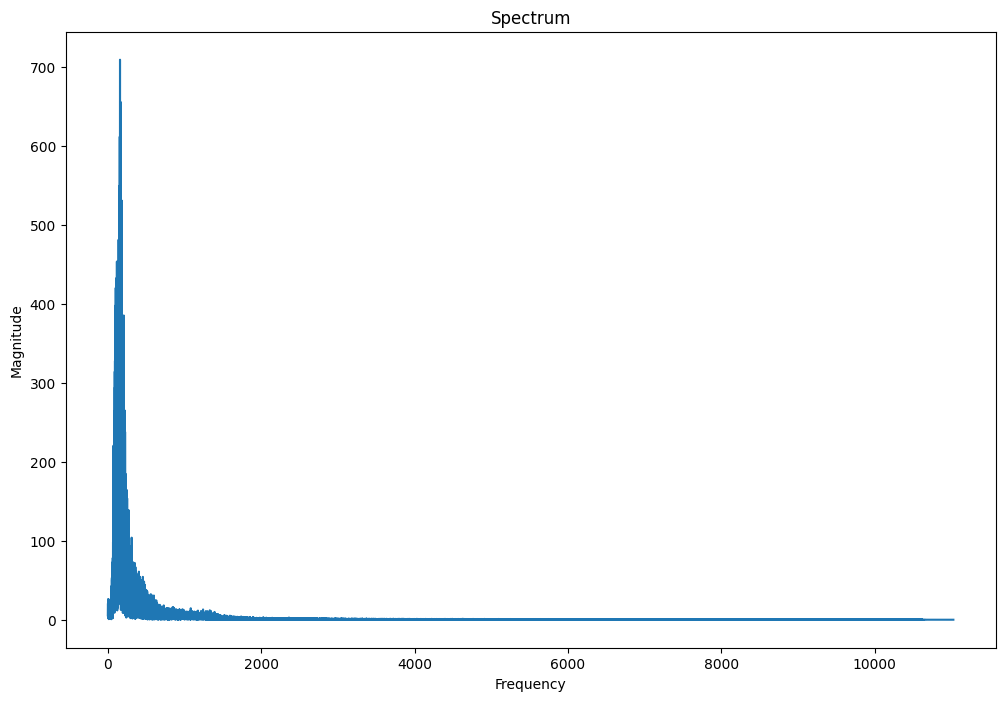

In [ ]:
show_audio_spectrum(extrahls_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


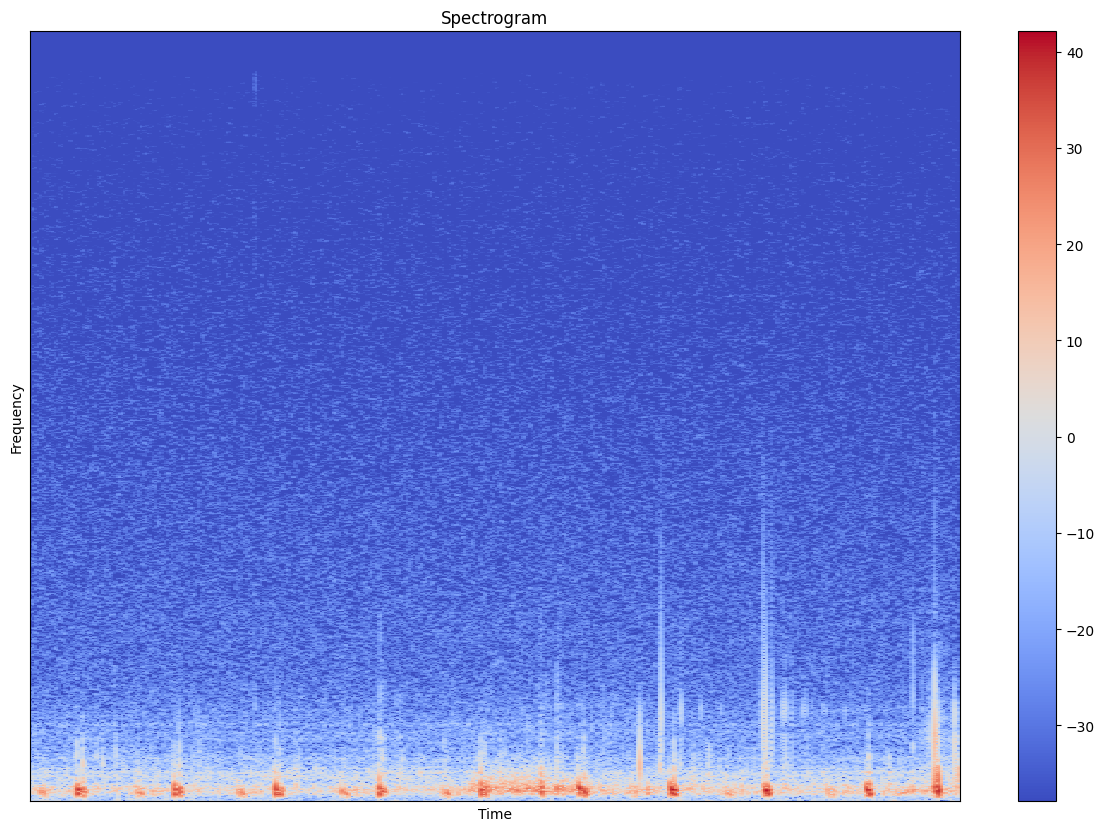

In [ ]:
show_spectrogram(extrahls_sample)

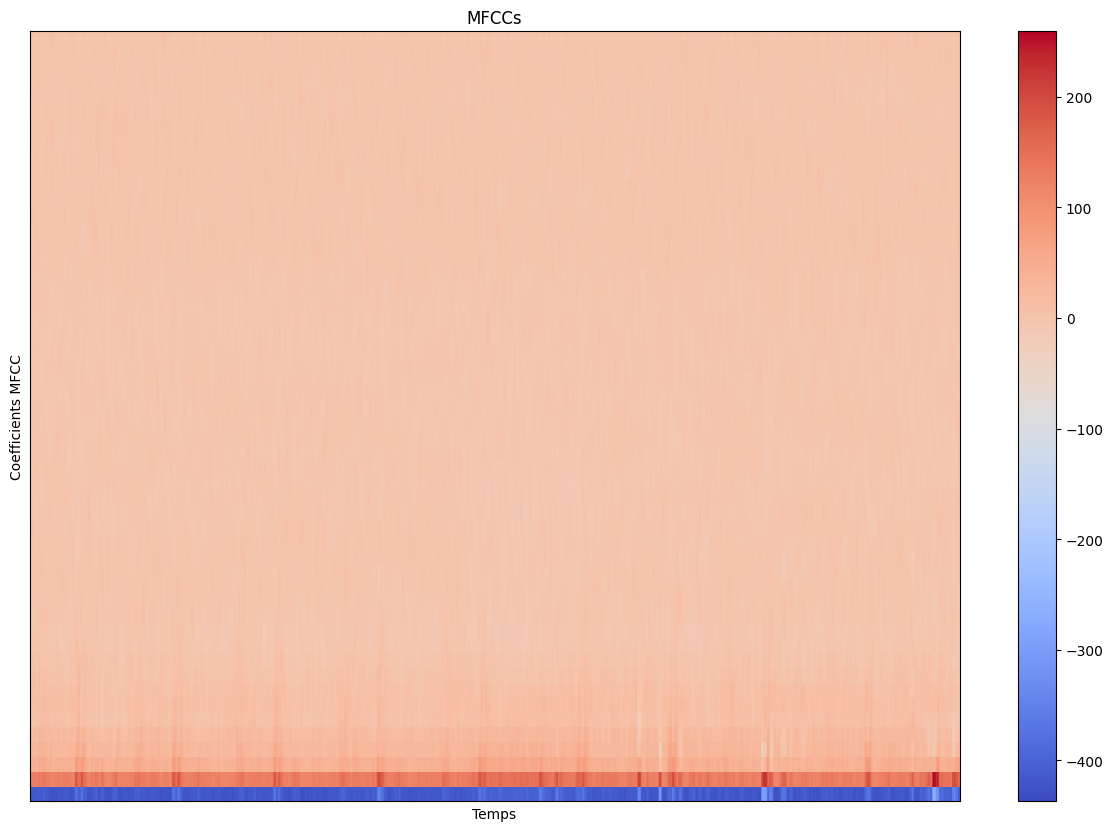

In [ ]:
show_mfcc_features(extrahls_path)


## Data Preprocessing

In [ ]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate=rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [ ]:
def load_file_data (folder, file_names, duration=10, sr=22050):
    '''
        Extract MFCC feature from the Sound data from the audio data.
        Augmentation of sound data by adding Noise, streaching and shifting.
        52 features are extracted from each audio data and used to train the model.

        Args:
            dir_: Input directory to the Sound input file.

        Returns:
            data: list of features extracted from the sound file.
    '''
    input_length=sr*duration
    features = 52
    data = []
    for file_name in file_names:
        try:
            sound_file = folder+file_name
            X, sr = librosa.load( sound_file, sr=sr, duration=duration)
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                X = librosa.util.fix_length(X,size=input_length)

            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=features).T,axis=0)
            feature = np.array(mfccs).reshape([-1,1])
            data.append(feature)

            stretch_data_1 = stretch (X, 0.8)
            mfccs_stretch_1 = np.mean(librosa.feature.mfcc(y=stretch_data_1, sr=sr, n_mfcc=features).T,axis=0)
            feature_1 = np.array(mfccs_stretch_1).reshape([-1,1])
            data.append(feature_1)

            stretch_data_2 = stretch (X, 1.2)
            mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=stretch_data_2, sr=sr, n_mfcc=features).T,axis=0)
            feature_2 = np.array(mfccs_stretch_2).reshape([-1,1])
            data.append(feature_2)

        except Exception as e:
            print("Error encountered while parsing file: ", file_name)

    return data

## Encoding

In [ ]:
# simple encoding of categories, convert to only 3 types:
# Normal (Include extrahls and extrastole)
# Murmur
# Artifact

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


## Data Augmenation and Feature Extraction

In [ ]:
# 22 KHz
SAMPLE_RATE = 22050
# 10 seconds
MAX_SOUND_CLIP_DURATION=10

artifact_files = fnmatch.filter(os.listdir(artifact_data), 'artifact*.wav')
artifact_sounds = load_file_data (folder=artifact_data, file_names = artifact_files)
artifact_labels = [0 for items in artifact_sounds]

normal_files = fnmatch.filter(os.listdir(normal_data), 'normal*.wav')
normal_sounds = load_file_data(folder=normal_data,file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_sounds]

extrahls_files = fnmatch.filter(os.listdir(extrahls_data), 'extrahls*.wav')
extrahls_sounds = load_file_data(folder=extrahls_data,file_names=extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
extrahls_labels = [2 for items in extrahls_sounds]

murmur_files = fnmatch.filter(os.listdir(murmur_data), 'murmur*.wav')
murmur_sounds = load_file_data(folder=murmur_data,file_names=murmur_files, duration=MAX_SOUND_CLIP_DURATION)
murmur_labels = [1 for items in murmur_sounds]


extrastole_files = fnmatch.filter(os.listdir(extrastole_data), 'extrastole*.wav')
extrastole_sounds = load_file_data(folder=extrastole_data,file_names=extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
extrastole_labels = [2 for items in extrastole_sounds]

print ("Loading Done")

fixing audio lenght : artifact__201105051017.wav
fixing audio lenght : artifact__201105061143.wav
fixing audio lenght : artifact__201106010559.wav
fixing audio lenght : artifact__201106031558.wav
fixing audio lenght : artifact__201106040933.wav
fixing audio lenght : artifact__201106010602.wav
fixing audio lenght : artifact__201105190800.wav
fixing audio lenght : artifact__201105280851.wav
fixing audio lenght : artifact__201012172012.wav
fixing audio lenght : artifact__201106021541.wav
fixing audio lenght : artifact__201105060108.wav
fixing audio lenght : artifact__201105040918.wav
fixing audio lenght : artifact__201105041959.wav
fixing audio lenght : artifact__201106030612.wav
fixing audio lenght : artifact__201106040722.wav
fixing audio lenght : artifact__201106131835.wav
fixing audio lenght : artifact__201106070949.wav
fixing audio lenght : artifact__201106212112.wav
fixing audio lenght : artifact__201106161016.wav
fixing audio lenght : artifact__201106101955.wav
fixing audio lenght 

In [ ]:
# unlabel_datala files
Bunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Bunlabelledtest*.wav')
Bunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Bunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Bunlabelledtest_labels = [-1 for items in Bunlabelledtest_sounds]

Aunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Aunlabelledtest*.wav')
Aunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Aunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Aunlabelledtest_labels = [-1 for items in Aunlabelledtest_sounds]


print ("Loading of unlabel data done")

fixing audio lenght : Bunlabelledtest__137_1306764999211_D2.wav
fixing audio lenght : Bunlabelledtest__154_1306935608852_A.wav
fixing audio lenght : Bunlabelledtest__217_1308246111629_B.wav
fixing audio lenght : Bunlabelledtest__118_1306262335509_C2.wav
fixing audio lenght : Bunlabelledtest__176_1307988171173_C1.wav
fixing audio lenght : Bunlabelledtest__101_1305030823364_F.wav
fixing audio lenght : Bunlabelledtest__175_1307987962616_C.wav
fixing audio lenght : Bunlabelledtest__163_1307104470471_B.wav
fixing audio lenght : Bunlabelledtest__125_1306332456645_B2.wav
fixing audio lenght : Bunlabelledtest__118_1306262335509_A1.wav
fixing audio lenght : Bunlabelledtest__187_1308073994223_C.wav
fixing audio lenght : Bunlabelledtest__141_1306520154450_D.wav
fixing audio lenght : Bunlabelledtest__245_1309198844065_A.wav
fixing audio lenght : Bunlabelledtest__146_1306778707532_D31.wav
fixing audio lenght : Bunlabelledtest__152_1306779561195_D1.wav
fixing audio lenght : Bunlabelledtest__287_1311

## Concatenation

In [ ]:
#combine set-a and set-b
x_data = np.concatenate((artifact_sounds, normal_sounds,extrahls_sounds,murmur_sounds,extrastole_sounds))

y_data = np.concatenate((artifact_labels, normal_labels,extrahls_labels,murmur_labels,extrastole_labels))

test_x = np.concatenate((Aunlabelledtest_sounds,Bunlabelledtest_sounds))
test_y = np.concatenate((Aunlabelledtest_labels,Bunlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))


combined training data record:  1755 741


## Data Split

In [ ]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

## Correct Imbalnced Data

In [ ]:
# class weight
TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #artifact
COUNT_1 = 129 #murmur
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

## **LSTM Model**

In [ ]:
x_train_lstm = x_train
x_val_lstm = x_test
x_test_lstm = x_val

y_train_lstm = y_train
y_val_lstm = y_test
y_test_lstm = y_val

## Build Model

In [ ]:
lstm_model = Sequential()

lstm_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(LSTM(128))

lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(3, activation='softmax'))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 52, 2048)          12288     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 26, 2048)          0         
 g1D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 26, 2048)          8192      
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 26, 1024)          10486784  
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 13, 1024)          0         
 g1D)                                                            
                                                      

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/kaggle/working/Heart_LSTM_CNN_1.h5",save_best_only=True)]

## Train Model

In [ ]:
%%time
history = lstm_model.fit(x_train_lstm, y_train_lstm,
                         validation_data=(x_val_lstm, y_val_lstm),
                         batch_size=8, epochs=200,
                         class_weight=class_weight,callbacks = cb )

Epoch 1/200
158/158 [==============================] - 12s 31ms/step - loss: 0.9377 - accuracy: 0.4228 - val_loss: 0.9273 - val_accuracy: 0.5385
Epoch 2/200
158/158 [==============================] - 4s 28ms/step - loss: 0.8323 - accuracy: 0.4972 - val_loss: 0.7834 - val_accuracy: 0.7379
Epoch 3/200
158/158 [==============================] - 4s 24ms/step - loss: 0.7068 - accuracy: 0.5574 - val_loss: 0.8940 - val_accuracy: 0.2621
Epoch 4/200
158/158 [==============================] - 4s 25ms/step - loss: 0.6636 - accuracy: 0.5764 - val_loss: 0.7102 - val_accuracy: 0.7265
Epoch 5/200
158/158 [==============================] - 3s 22ms/step - loss: 0.6418 - accuracy: 0.5629 - val_loss: 0.8092 - val_accuracy: 0.7123
Epoch 6/200
158/158 [==============================] - 4s 28ms/step - loss: 0.6469 - accuracy: 0.5629 - val_loss: 0.6775 - val_accuracy: 0.7322
Epoch 7/200
158/158 [==============================] - 3s 22ms/step - loss: 0.5971 - accuracy: 0.5717 - val_loss: 0.7104 - val_accuracy

In [ ]:
lstm_model.save_weights("lstm_model_weights.h5")

## Evaluate Model

In [ ]:
lstm_model.evaluate(x_val_lstm, y_val_lstm)

11/11 [==============================] - 1s 40ms/step - loss: 0.1951 - accuracy: 0.9687


[0.19512571394443512, 0.9686609506607056]

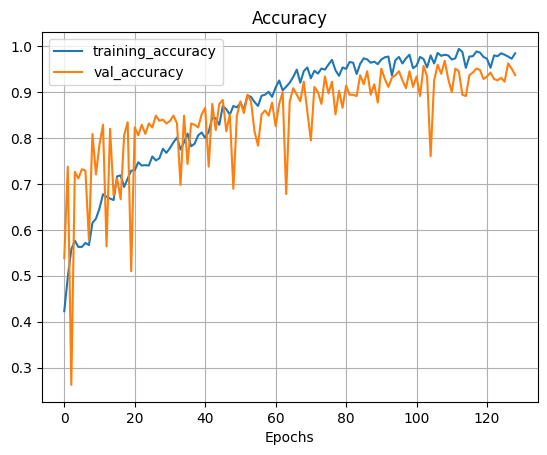

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history)

## Results

5/5 [==============================] - 1s 56ms/step


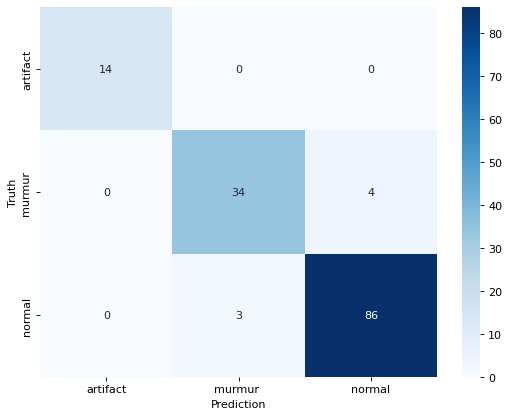

In [ ]:
classes = ["artifact" ,"murmur ", "normal"]

preds = lstm_model.predict(x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_lstm]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
end_time = time.time()
total_time = end_time - start_time

hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)

print("Temps d'exécution total:", hours, "heures,", minutes, "minutes et", seconds, "secondes")

In [ ]:
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)

print("Temps d'exécution total:", hours, "heures,", minutes, "minutes et", seconds, "secondes")

Temps d'exécution total: 0 heures, 12 minutes et 45 secondes


## Prediction

In [ ]:
def heart_prediction (file_path, duration=10, sr=22050):
    classes=["artifact","murmur","normal"]
    input_length=sr*duration

    X, sr = librosa.load(file_path, sr=sr, duration=duration)
    dur = librosa.get_duration(y=X, sr=sr)

    # pad audio file same duration
    if (round(dur) < duration):
        X = librosa.util.fix_length(X,size= input_length)

    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=52, n_fft=512,hop_length=2048).T,axis=0)
    feature = np.array(mfccs).reshape([-1,1])

    preds=lstm_model.predict(mfccs.reshape(1,52,1))
    preds=classes [np.argmax(preds)]
    confidence = np.amax(preds)
    return preds, confidence

In [ ]:
def heart_prediction(file_path, duration=10, sr=22050):
    classes = ["artifact", "murmur", "normal"]
    input_length = sr * duration

    X, sr = librosa.load(file_path, sr=sr, duration=duration)
    dur = librosa.get_duration(y=X, sr=sr)

    # pad audio file same duration
    if round(dur) < duration:
        X = librosa.util.fix_length(X, size=input_length)

    # Extraire les caractéristiques MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=52, n_fft=512, hop_length=2048).T, axis=0)

    # Redimensionner les caractéristiques MFCC pour l'entrée du modèle
    mfccs_input = mfccs.reshape(1, 52, 1)

    # Faire des prédictions avec le modèle LSTM
    preds = lstm_model.predict(mfccs_input)

    # Obtenir la classe prédite avec la plus grande probabilité
    pred_class_index = np.argmax(preds)
    pred_class = classes[pred_class_index]

    # Obtenir la probabilité de confiance de la prédiction
    confidence = np.amax(preds)

    return pred_class, confidence


In [ ]:
lstm_model.save_weights("/content/drive/MyDrive/datasets/lstm_model_weights.h5")

In [ ]:
pred_class=heart_prediction("/content/drive/MyDrive/datasets/Heartbeat_Sound/unlabel/Aunlabelledtest__201012172010.wav")
print("IL s'agit de:", pred_class[0])

1/1 [==============================] - 0s 61ms/step
IL s'agit de: artifact
